# Assignment 3

In [1]:
import matplotlib.pyplot as plt
from skimage import io
from sklearn import svm, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import cv2
import numpy as np
import os
import time

path = "/home/emile/git/ecse415/A3/"

## 1. CIFAR10 Classification using SVM and Random Forest

In [2]:
images = []

image_size = (64, 64)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

train_data = []
train_data.append(unpickle(path + "/cifar-10-batches-py/data_batch_1"))
train_data.append(unpickle(path + "/cifar-10-batches-py/data_batch_2"))
train_data.append(unpickle(path + "/cifar-10-batches-py/data_batch_3"))
train_data.append(unpickle(path + "/cifar-10-batches-py/data_batch_4"))
train_data.append(unpickle(path + "/cifar-10-batches-py/data_batch_5"))

train_labels = []

### 1.1

In [3]:
for dic in train_data:
    for i in range(0, 10000):
        image = dic[b'data'][i].reshape(3, 32, 32).transpose(1, 2, 0)
        resize = cv2.resize(image, image_size)
        gray = cv2.cvtColor(resize, cv2.COLOR_RGB2GRAY)
        images.append(gray)
        train_labels.append(dic[b'labels'][i])


test_data = unpickle(path + "/cifar-10-batches-py/test_batch")
test_images = []
test_labels = []

for i in range(0, 10000):
    image = test_data[b'data'][i].reshape(3, 32, 32).transpose(1, 2, 0)
    resize = cv2.resize(image, image_size)
    gray = cv2.cvtColor(resize, cv2.COLOR_RGB2GRAY)
    test_images.append(gray)
    test_labels.append(test_data[b'labels'][i])

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

cell_size = (8, 8)  # h x w in pixels
block_size = (4, 4)  # h x w in cells
nbins = 4  # number of orientation bins

hog = cv2.HOGDescriptor(_winSize=(image_size[1] // cell_size[1] * cell_size[1],
                                    image_size[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

features = []
for i in range(len(images)):
    features.append(hog.compute(images[i].astype(np.uint8)).reshape(1, -1))
features = np.vstack(features)


test_features = []
for i in range(0, len(test_images)):
    test_features.append(hog.compute(test_images[i].astype(np.uint8)).reshape(1, -1))
test_features = np.vstack(test_features)

### 1.2

In [4]:
clf = svm.SVC()
clf.fit(features, train_labels)

SVC()

### 1.3

In [5]:
predicted = clf.predict(test_features)
acc = np.mean(predicted == test_labels)
print("Default Accuracy: ", acc)

Default Accuracy:  0.6388


### 1.4

In [6]:
validation_images = images[0:len(images)//10]
validation_labels = train_labels[0:len(train_labels)//10]
validation_features = features[0:len(features)//10]

max_accuracy = 0
max_c = 0
max_gamma = 'scale'
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

c_rt = []
acc_rt = []
for c in c_values:
    start = time.time()
    clf = svm.SVC(gamma='auto', C=c)
    clf.fit(validation_features, validation_labels)
    predicted = clf.predict(test_features)
    c_rt.append(time.time() - start)
    acc = np.mean(predicted == test_labels)
    acc_rt.append(acc)
    print("Gamma: Auto, C = " + str(c) + " Accuracy: ", acc)
    if acc > max_accuracy:
        max_accuracy = acc
        max_c = c
        max_gamma = 'auto'
    clf = svm.SVC(C=c)
    clf.fit(validation_features, validation_labels)
    predicted = clf.predict(test_features)
    acc = np.mean(predicted == test_labels)
    print("Gamma: Scale, C = " + str(c) + " Accuracy: ", acc, "\n")
    if acc > max_accuracy:
        max_accuracy = acc
        max_c = c
        max_gamma = 'scale'

print("Max Accuracy: ", max_accuracy)
print("C: ", max_c)
print("Gamma: ", max_gamma)

clf = svm.SVC(gamma=max_gamma, C=max_c)
clf.fit(features[len(features)//10:], train_labels[len(train_labels)//10:])
predicted = clf.predict(test_features)
acc = np.mean(predicted == test_labels)
print("Accuracy with fine-tuned hyperparameter: ", acc)

Gamma: Auto, C = 0.001 Accuracy:  0.1
Gamma: Scale, C = 0.001 Accuracy:  0.1 

Gamma: Auto, C = 0.01 Accuracy:  0.1
Gamma: Scale, C = 0.01 Accuracy:  0.2413 

Gamma: Auto, C = 0.1 Accuracy:  0.1
Gamma: Scale, C = 0.1 Accuracy:  0.4383 

Gamma: Auto, C = 1 Accuracy:  0.2377
Gamma: Scale, C = 1 Accuracy:  0.5123 

Gamma: Auto, C = 10 Accuracy:  0.421
Gamma: Scale, C = 10 Accuracy:  0.5389 

Gamma: Auto, C = 100 Accuracy:  0.4619
Gamma: Scale, C = 100 Accuracy:  0.5386 

Gamma: Auto, C = 1000 Accuracy:  0.4541
Gamma: Scale, C = 1000 Accuracy:  0.5386 

Max Accuracy:  0.5389
C:  10
Gamma:  scale
Accuracy with fine-tuned hyperparameter:  0.6697


Hyperparameter fine-tuning is done by evaluating accuracy on a validation set of size test_size / 10. Various values for C are tested at both Gamma:auto (1/number of features) and Gamma:Scale (1/(number of features * X.var)). We choose a small validation set to allow for testing of multiple hyperparameters in an acceptable time. While the accuracy of the validation set predictions does not reflect the final accuracy with the full training data, it can give us insights on which hyperparameter results in the better accuracy. The best combination of hyperparamter is then chosen for the final accuracy test.

### 1.5

In [7]:
clf = RandomForestClassifier(n_estimators=10, max_depth=5, criterion='entropy')
clf.fit(features, train_labels)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=10)

### 1.6

In [8]:
clf.predict(test_features)
acc = np.mean(predicted == test_labels)
print("Random Forest Accuracy: ", acc)

Random Forest Accuracy:  0.6697


### 1.7

Random Forest Runtime analysis for number of estimators at constant max depth (5)


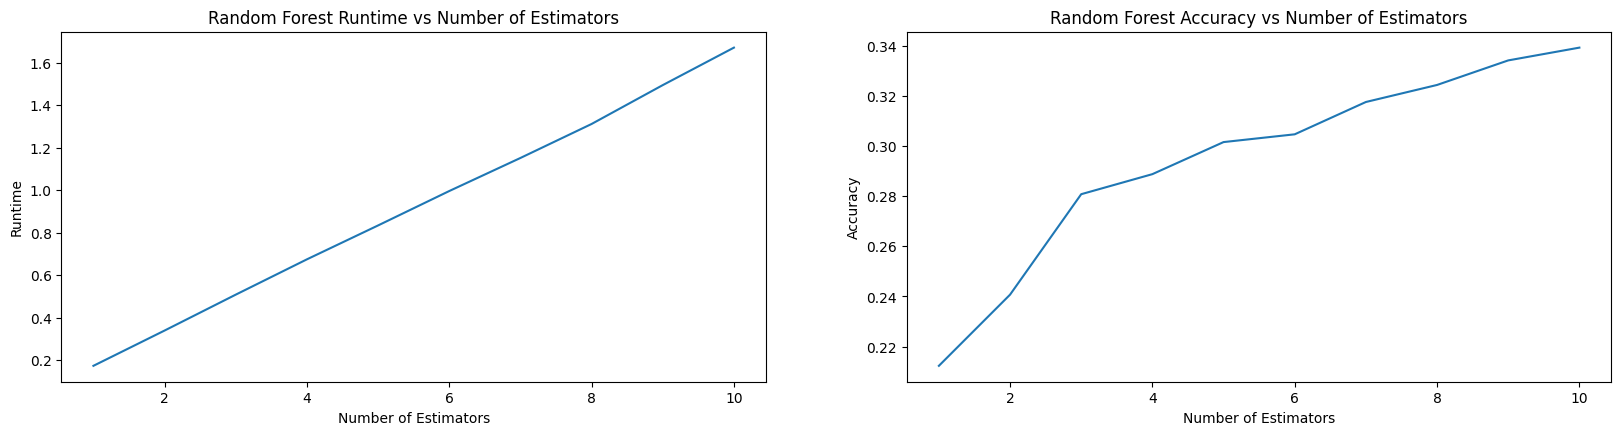

Random Forest Runtime analysis for max depth at constant number of estimators (10)


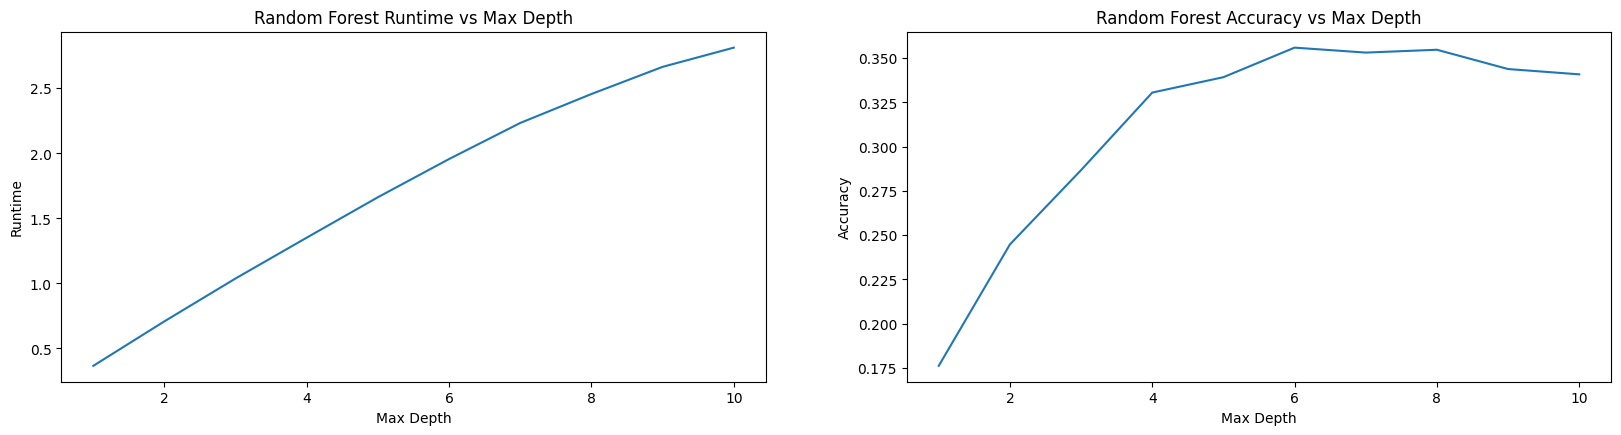

In [9]:
depth_rt = []
depth_acc = []
n_estimators_rt = []
n_estimators_acc = []

for i in range(1, 11):
    start = time.time()
    clf = RandomForestClassifier(n_estimators=i, max_depth=5, criterion='entropy')
    clf.fit(validation_features, validation_labels)
    predicted = clf.predict(test_features)
    n_estimators_rt.append(time.time() - start)
    acc = np.mean(predicted == test_labels)
    n_estimators_acc.append(acc)

for i in range(1, 11):
    start = time.time()
    clf = RandomForestClassifier(n_estimators=10, max_depth=i, criterion='entropy')
    clf.fit(validation_features, validation_labels)
    predicted = clf.predict(test_features)
    depth_rt.append(time.time() - start)
    acc = np.mean(predicted == test_labels)
    depth_acc.append(acc)

print("Random Forest Runtime analysis for number of estimators at constant max depth (5)")

plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.plot(range(1, 11), n_estimators_rt)
plt.xlabel('Number of Estimators')
plt.ylabel('Runtime')
plt.title('Random Forest Runtime vs Number of Estimators')

plt.subplot(222)
plt.plot(range(1, 11), n_estimators_acc)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs Number of Estimators')
plt.show()

print("Random Forest Runtime analysis for max depth at constant number of estimators (10)")

plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.plot(range(1, 11), depth_rt)
plt.xlabel('Max Depth')
plt.ylabel('Runtime')
plt.title('Random Forest Runtime vs Max Depth')

plt.subplot(222)
plt.plot(range(1, 11), depth_acc)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs Max Depth')
plt.show()


Runtime analysis is once again done with a validation set of size training_size/10 to speed up the process. These runtimes should reflect the trend with the full training set.

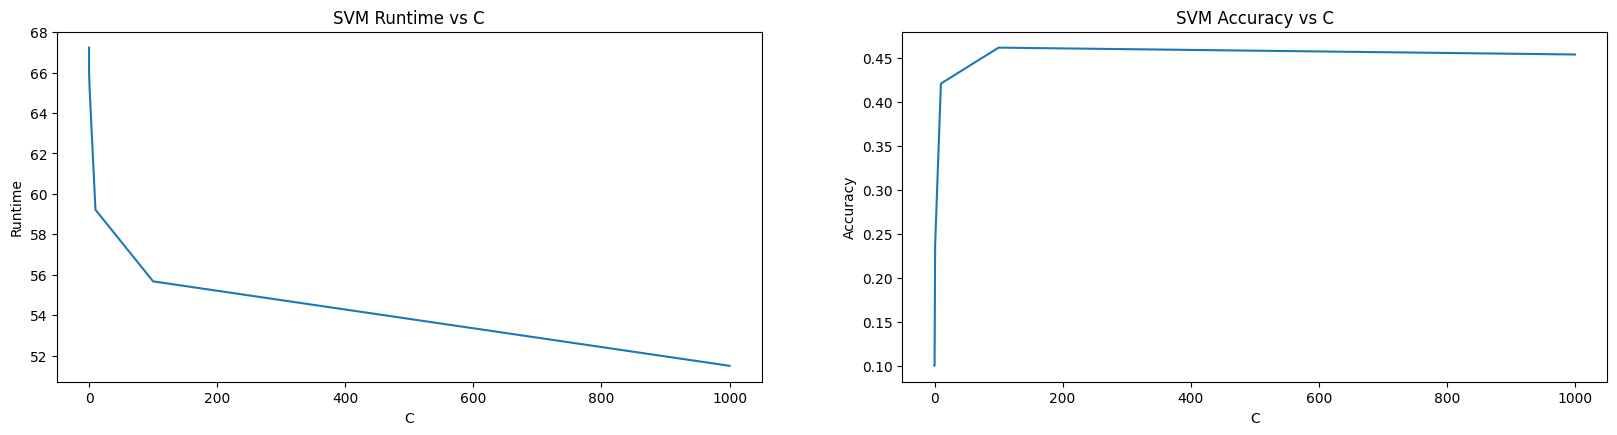

In [10]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.plot(c_values, c_rt)
plt.xlabel('C')
plt.ylabel('Runtime')
plt.title('SVM Runtime vs C')

plt.subplot(222)
plt.plot(c_values, acc_rt)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy vs C')
plt.show()

Runtime analysis for SVM is also done with the validation set of size training_set/10. As we can see from the graphs.

From the graphs above, we see that Random Tree seems to be generally faster, but result in lower accuracy for the same validation set size.

## 2. Face Detection

### 2.1

In [11]:
images = []
h = 0
w = 0
for image in os.listdir(path + "A3-W24-images/Q2 part1/"):
    img = cv2.imread(path + "A3-W24-images/Q2 part1/" + image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if(len(images) == 0):
        h = gray.shape[0]
        w = gray.shape[1]
    images.append(gray.flatten())

scaler = StandardScaler()
images = scaler.fit_transform(images)



### 2.2

D:  (100, 38804)
Dt:  (38804, 100)
Dt_d:  (100, 100)
Top:  (100, 5)
Temp:  (38804, 5)
Eigenfaces:  (5, 218, 178)
Top five eigenfaces


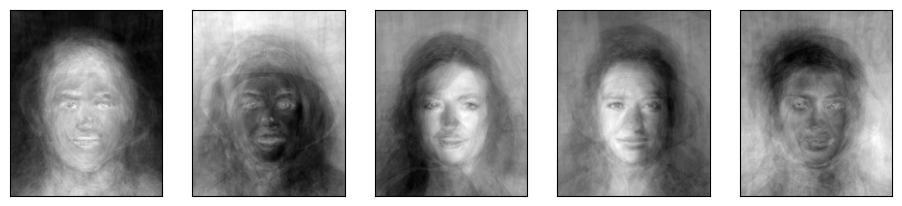

In [12]:
D = np.array(images)
#D = np.transpose(images)
print("D: ", D.shape)
Dt = np.transpose(D)
print("Dt: ", Dt.shape)
Dt_d = np.matmul(D, Dt)
print("Dt_d: ", Dt_d.shape)

eigenvalues, eigenvectors = np.linalg.eig(Dt_d)
index = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[index]
eigenvectors = eigenvectors[:, index]

top = eigenvectors[:, 0:5]
print("Top: ", top.shape)

temp = np.matmul(Dt, top)
print("Temp: ", temp.shape)
eigenfaces = np.transpose(temp).reshape(5, h, w)
print("Eigenfaces: ", eigenfaces.shape)

avg_face = np.mean(D, axis=0)

def plot_gallery(images, h, w, n_row=3, n_col=4): #taken from tutorial
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

print("Top five eigenfaces")
plot_gallery(eigenfaces, h, w, n_row=1, n_col=5)


### 2.3 - 2.5

Runtime:  3.834531545639038
Detection:  47


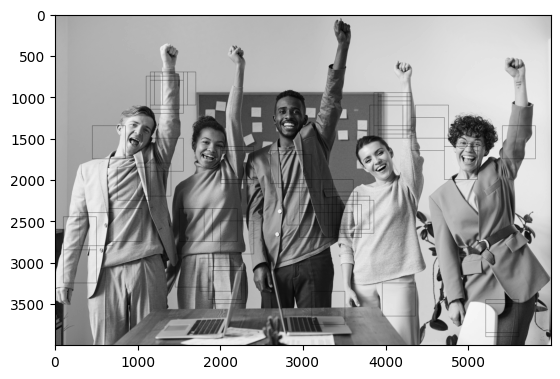

In [13]:
img = cv2.imread(path + "A3-W24-images/Q2 part2/Person.png")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
detection = []
THRESHOLD = 1000000

windowH = 400
windowW = 400

startTime = time.time()
for i in range(0, gray.shape[0] - windowH, 50):
    for j in range(0, gray.shape[1] - windowW, 50):
        window = gray[i:i+windowH, j:j+windowW]
        
        if window.shape[0] != windowH or window.shape[1] != windowW:
            continue

        window = cv2.resize(window, (h,w))

        window_flattened = window.flatten()
        window_normalized = (window_flattened - np.mean(window_flattened)) / np.std(window_flattened)


        window_projected = np.dot(temp.T, window_normalized - avg_face)

        reconstruction = np.dot(temp, window_projected) + avg_face
        dist = np.linalg.norm(window_normalized - reconstruction)



        if dist < THRESHOLD:
            detection.append((i, j))

runtime = time.time() - startTime
print("Runtime: ", runtime)


for i, j in detection:
    gray = cv2.rectangle(gray, (j, i), (j + windowW, i + windowH), (0, 255, 0), 2)

print("Detection: ", len(detection))

plt.imshow(gray, cmap=plt.cm.gray)

        

Unfortunately, face detection could not be implemented accurately. This threshold was selected after trying every power of 10s up to this one. Below this current threshold only 3 detections are made, and do not represent faces. This one was chosen because it recognizes some part of faces for some detection.

### 2.6

Faces:  4
Runtime:  0.800945520401001


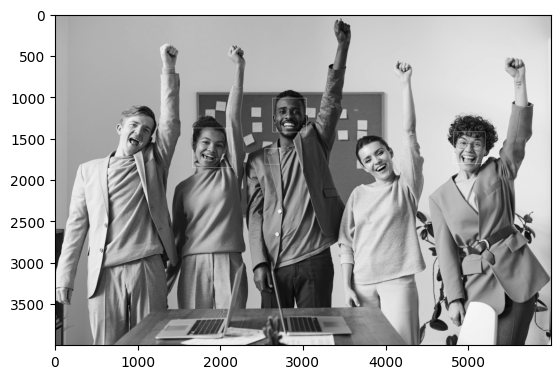

In [14]:
face_cascade = cv2.CascadeClassifier(path+'haarcascade_frontalface_default.xml')

img = cv2.imread(path + "A3-W24-images/Q2 part2/Person.png")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

startTime = time.time()
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
print("Faces: ", len(faces))
print("Runtime: ", time.time() - startTime)

for (x, y, w, h) in faces:
    gray = cv2.rectangle(gray, (x, y), (x+w, y+h), (255, 0, 0), 2)

plt.imshow(gray, cmap=plt.cm.gray)
plt.show()


### 2.7

For the sliding window method, 47 detections were made using a treshold of 1000000. Out of those, only 2 represents some part of a face. All the other detections seem to point to features that present contrast and change in magnitude, like arms or folds in clothes

For the existing Viola-Jone method, 4 detections were made, from which 3 detections successfully identify a face out of the 5 present in the picture. The other detection is an error.

### 2.8

Viola-Jones has the advantage of being able to quickly discard windows of an image that are sure to not be a face, by using a cascading method. This makes it good for real-time detection, as detection can be really fast as it is specifically designed for detecting objects in an image. On the other hand, PCA might be too slow for real-time purposes, but might return more precise detection and can be used to generate objects from a training set, like faces.

### 2.9

The PCA method had a runtime of 4.89 seconds and it was taking incremental steps of 50 pixels for each window. The Viola-Jones method took 0.60 seconds. That is because Viola-Jones has Cascading abilities, where it can quickly discard evaluated windows that are sure to not have a face, and only evaluate more precisely those that might contain one. Furthermore, it uses integral image for feature detection, which speeds up the process further.